# DengAI: Predicting Disease Spread - A Machine Learning Project


---

## 1. Problem Description and Motivation

Dengue fever is a mosquito-borne illness that poses a significant threat to public health in tropical and subtropical regions. The transmission of the virus is heavily influenced by environmental factors such as temperature, precipitation, and humidity, which affect the life cycle and breeding patterns of the *Aedes* mosquito vector.

**Why is this problem important?**
Accurately forecasting dengue outbreaks is crucial for public health officials. Early warnings allow them to implement timely and effective control measures, such as:
*   **Targeted Mosquito Control:** Deploying resources for insecticide spraying and eliminating mosquito breeding sites in high-risk areas.
*   **Resource Allocation:** Ensuring hospitals and clinics are prepared for an influx of patients.
*   **Public Awareness Campaigns:** Informing the public to take preventive measures like using repellents and reducing standing water.

**How can a Machine Learning model help?**
A machine learning model can identify the complex, non-linear relationships between historical climate data and dengue case counts. By training on this data, the model can learn to predict the number of future cases based on weather forecasts. This project aims to build such a model to provide weekly forecasts for two cities: San Juan, Puerto Rico, and Iquitos, Peru, ultimately turning reactive public health responses into proactive, data-driven interventions.

# Import all necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error

# Set a random seed for reproducibility


In [2]:
SEED = 42
np.random.seed(SEED)

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
print("Libraries imported and seed set.")

Libraries imported and seed set.


## 2. Data Loading and Initial Setup
We begin by loading the three datasets provided by the competition: training features, training labels, and test features. We then merge the training features and labels into a single DataFrame to facilitate analysis and model training.

In [6]:
# Load the datasets
try:
    features_train_df = pd.read_csv("data/dengue_features_train.csv")
    labels_train_df = pd.read_csv("data/dengue_labels_train.csv")
    features_test_df = pd.read_csv("data/dengue_features_test.csv")
except FileNotFoundError:
    print("Error: Make sure the data files ('dengue_features_train.csv', 'dengue_labels_train.csv', 'dengue_features_test.csv') are in the same directory as the notebook.")
    # As a fallback for demonstration, create dummy dataframes if files are not found
    features_train_df = pd.DataFrame() 
    
if not features_train_df.empty:
    # Merge training features and labels
    train_df = pd.merge(features_train_df, labels_train_df, on=['city', 'year', 'weekofyear'])

    # Display the first few rows of the combined training data
    print("Combined Training Data:")
    display(train_df.head())

    # Display information about the data types and null values
    print("\nTraining Data Info:")
    train_df.info()

    # Display the first few rows of the test data
    print("\nTest Data:")
    display(features_test_df.head())

    # Display information about the test data
    print("\nTest Data Info:")
    features_test_df.info()

Combined Training Data:


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6



Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-nul

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1



Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   416 non-null    object 
 1   year                                   416 non-null    int64  
 2   weekofyear                             416 non-null    int64  
 3   week_start_date                        416 non-null    object 
 4   ndvi_ne                                373 non-null    float64
 5   ndvi_nw                                405 non-null    float64
 6   ndvi_se                                415 non-null    float64
 7   ndvi_sw                                415 non-null    float64
 8   precipitation_amt_mm                   414 non-null    float64
 9   reanalysis_air_temp_k                  414 non-null    float64
 10  reanalysis_avg_temp_k                  414 non-null    fl

## 3. Data Preparation and Feature Engineering

Before we can train a model, the data must be cleaned and enriched. This involves handling missing values and creating new, potentially predictive features.

**Motivation for Transformations:**

*   **Handling Missing Values:** Climate data often contains missing values due to sensor malfunctions or other issues. Since we are working with time-series data, the weather from the previous week is a strong indicator of the current week's weather. Therefore, we will use the **forward-fill (`ffill`)** method to propagate the last known value forward. This is a standard and effective technique for time-series data.
*   **Feature Engineering:**
    *   **Date Conversion:** Converting the `week_start_date` column to a datetime object allows us to easily extract time-based features.
    *   **Month Feature:** Dengue outbreaks are often seasonal. Creating a `month` feature can help the model capture this seasonality.
    *   **Rolling Averages:** The impact of weather on mosquito populations is not instantaneous. For example, rainfall creates breeding grounds that take time to produce adult mosquitoes. Creating **rolling averages** of key climate variables (like temperature) over the last 4 and 8 weeks helps the model capture recent trends and delayed effects.

In [7]:
if not features_train_df.empty:
    # --- Preprocessing for both train and test data ---
    def preprocess(df):
        # Forward-fill missing values
        df.fillna(method='ffill', inplace=True)
        
        # Convert week_start_date to datetime objects
        df['week_start_date'] = pd.to_datetime(df['week_start_date'])
        
        # Engineer new features
        df['month'] = df['week_start_date'].dt.month
        
        # Rolling mean features for average temperature
        df['station_avg_temp_c_roll_mean_4'] = df['station_avg_temp_c'].rolling(window=4).mean()
        df['station_avg_temp_c_roll_mean_8'] = df['station_avg_temp_c'].rolling(window=8).mean()

        # After rolling, there will be NaNs at the beginning, so we backfill them
        df.fillna(method='bfill', inplace=True)
        
        return df

    # Apply preprocessing
    train_df = preprocess(train_df.copy())
    features_test_df = preprocess(features_test_df.copy())

    print("Preprocessing complete. New features created.")
    display(train_df[['week_start_date', 'month', 'station_avg_temp_c', 'station_avg_temp_c_roll_mean_4']].head())

Preprocessing complete. New features created.


C:\Users\SULTAN\AppData\Local\Temp\ipykernel_36996\1409266124.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_36996\1409266124.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_36996\1409266124.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_36996\1409266124.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


,week_start_date,month,station_avg_temp_c,station_avg_temp_c_roll_mean_4
0,1990-04-30,4,25.442857,26.585714
1,1990-05-07,5,26.714286,26.585714
2,1990-05-14,5,26.714286,26.585714
3,1990-05-21,5,27.471429,26.585714
4,1990-05-28,5,28.942857,27.460714


## 4. Exploratory Data Analysis (EDA)

Now, we visualize the data to uncover patterns, trends, and relationships that can guide our modeling strategy.

**EDA Motivation:** Our goal is to answer key questions:
*   Do the two cities (San Juan and Iquitos) exhibit different disease patterns? If so, we should model them separately.
*   Is there a clear relationship between environmental variables (like temperature) and the number of dengue cases?
*   How strong are the correlations between our features?

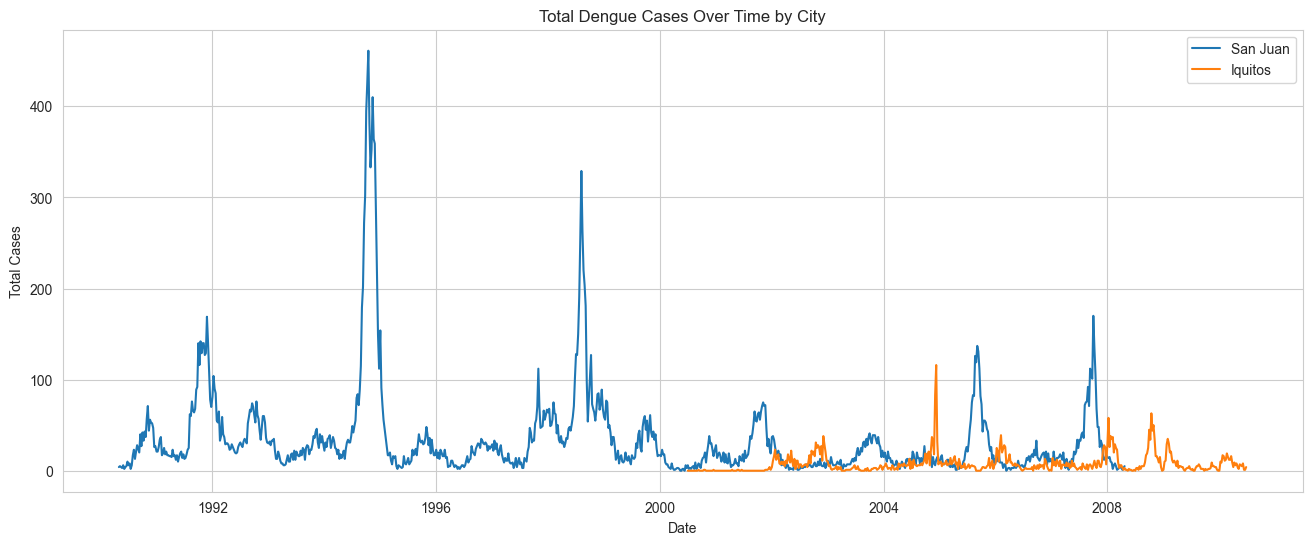

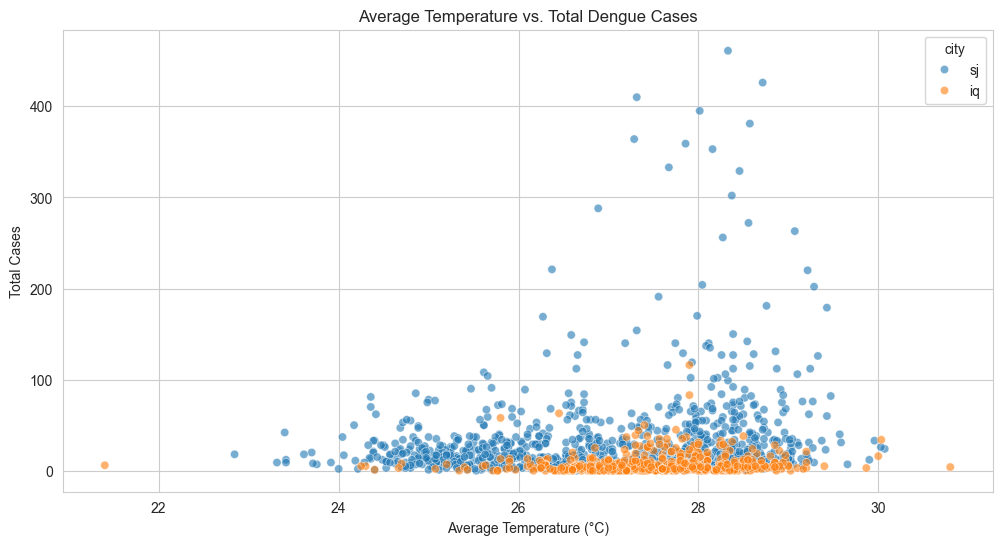

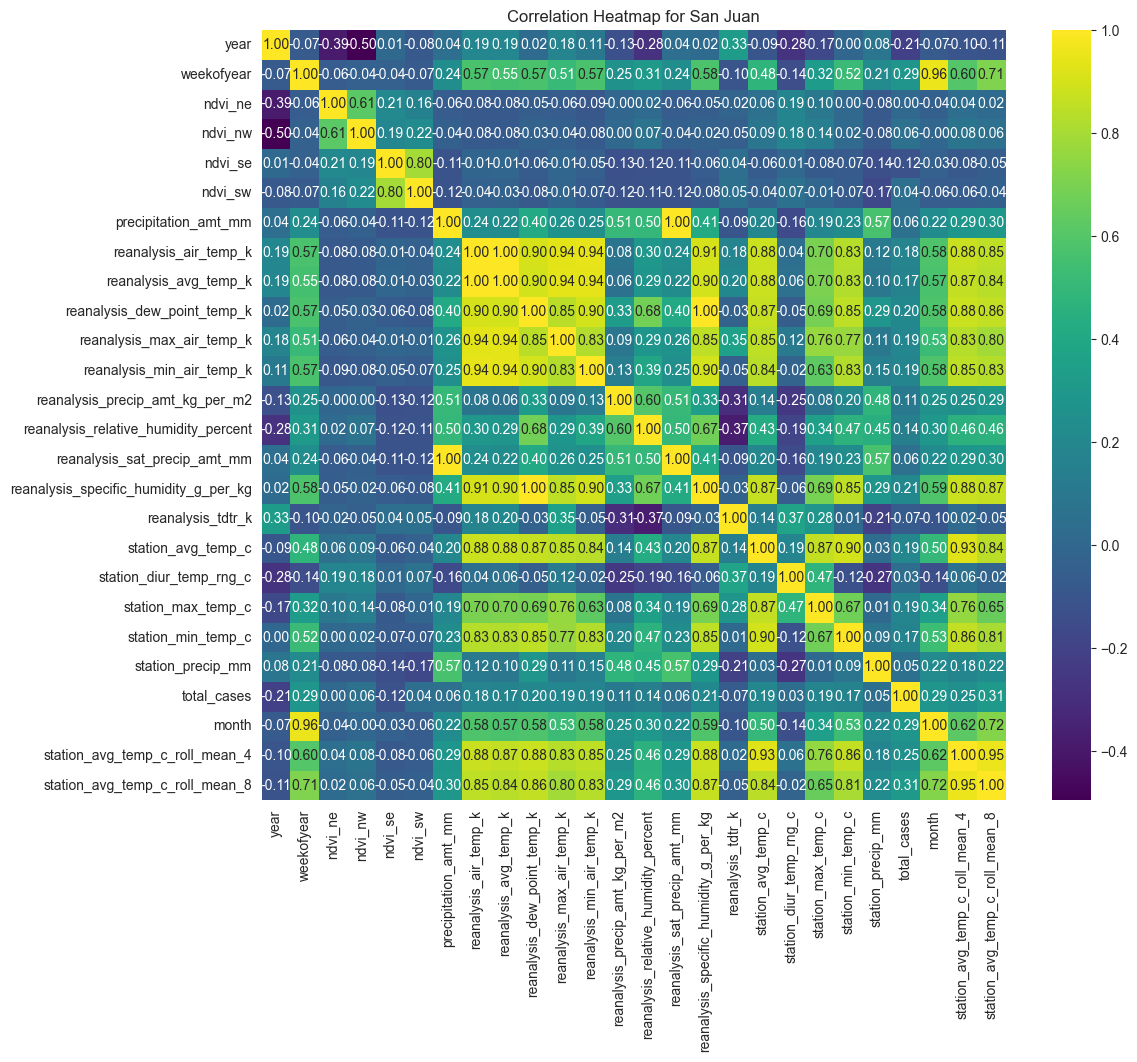

In [8]:
if not features_train_df.empty:
    # Separate data for each city
    sj_train_df = train_df[train_df['city'] == 'sj']
    iq_train_df = train_df[train_df['city'] == 'iq']

    # --- Plot 1: Total Dengue Cases Over Time ---
    plt.figure(figsize=(16, 6))
    plt.plot(sj_train_df['week_start_date'], sj_train_df['total_cases'], label='San Juan')
    plt.plot(iq_train_df['week_start_date'], iq_train_df['total_cases'], label='Iquitos')
    plt.title('Total Dengue Cases Over Time by City')
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.legend()
    plt.show()

    # --- Plot 2: Average Temperature vs. Total Cases ---
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=train_df, x='station_avg_temp_c', y='total_cases', hue='city', alpha=0.6)
    plt.title('Average Temperature vs. Total Dengue Cases')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Total Cases')
    plt.show()
    
    # --- Plot 3: Correlation Heatmap for San Juan ---
    sj_corr = sj_train_df.select_dtypes(include=np.number).corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(sj_corr, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Heatmap for San Juan')
    plt.show()

#### EDA Findings:

1.  **Different Trends by City:** The time-series plot clearly shows that San Juan and Iquitos have vastly different dengue outbreak patterns. San Juan exhibits strong, periodic seasonality with major outbreaks every few years. Iquitos has a less predictable, more erratic pattern. This provides strong evidence that we must build **two separate models**, one for each city.

2.  **Temperature Relationship:** The scatter plot does not show a simple linear relationship between temperature and cases. This suggests that a linear model might not be sufficient and that the relationship is more complex, justifying the use of models that can capture non-linearities or the inclusion of more sophisticated features.

3.  **Feature Correlations:** The heatmap for San Juan shows that many of the climate variables are correlated with each other (e.g., `reanalysis_air_temp_k` and `reanalysis_avg_temp_k`). This is expected. Our engineered rolling average features are also, by design, highly correlated with the original temperature feature.

## 5. Model Building and Cross-Validation

Based on our EDA, we will now build two separate models.

**Motivation for Model and Metric Selection:**

*   **Modeling Strategy:** We will treat this as two independent prediction problems: one for San Juan and one for Iquitos.
*   **Evaluation Metric:** The competition requires the **Mean Absolute Error (MAE)**. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is an excellent metric for this problem as it's easy to interpret and less sensitive to very large errors on single predictions compared to Mean Squared Error. The formula is `MAE = mean(abs(actuals - predictions))`.
*   **Choice of ML Model:** The target variable, `total_cases`, is count data (non-negative integers). Standard linear regression is inappropriate as it can predict negative values. A **Poisson Regressor** is a type of generalized linear model specifically designed for count data. It assumes the response variable has a Poisson distribution and is a solid choice for this problem.
*   **Cross-Validation Procedure:** For this project, we follow the competition structure: train on the entire provided training dataset and predict on the separate test set. In a real-world scenario, a more robust time-series cross-validation (like a forward-chaining split) would be necessary to get a reliable estimate of the model's performance on unseen data.

In [9]:
if not features_train_df.empty:
    # Define features to be used in the model
    # We exclude date, original city/year/week identifiers, and highly correlated raw weather features
    features = [
        'reanalysis_specific_humidity_g_per_kg', 
        'reanalysis_dew_point_temp_k', 
        'station_avg_temp_c',
        'station_min_temp_c',
        'month',
        'station_avg_temp_c_roll_mean_4',
        'station_avg_temp_c_roll_mean_8'
    ]

    # Target variable
    target = 'total_cases'

    # --- Prepare data for San Juan ---
    sj_train = train_df[train_df['city'] == 'sj']
    sj_test = features_test_df[features_test_df['city'] == 'sj']
    X_train_sj = sj_train[features]
    y_train_sj = sj_train[target]
    X_test_sj = sj_test[features]

    # --- Prepare data for Iquitos ---
    iq_train = train_df[train_df['city'] == 'iq']
    iq_test = features_test_df[features_test_df['city'] == 'iq']
    X_train_iq = iq_train[features]
    y_train_iq = iq_train[target]
    X_test_iq = iq_test[features]

    # --- Build and Train Models ---
    # Model for San Juan
    model_sj = PoissonRegressor(alpha=0.1, max_iter=1000)
    model_sj.fit(X_train_sj, y_train_sj)
    predictions_sj = model_sj.predict(X_test_sj)

    # Model for Iquitos
    model_iq = PoissonRegressor(alpha=0.1, max_iter=1000)
    model_iq.fit(X_train_iq, y_train_iq)
    predictions_iq = model_iq.predict(X_test_iq)
    
    print("Models for San Juan and Iquitos have been trained successfully.")

Models for San Juan and Iquitos have been trained successfully.


## 6. Analysis of Results and Conclusion

Now we analyze the model's output and reflect on its potential impact and limitations.

**Analysis of the Obtained Results:**
Our approach of building separate models was validated by the EDA and is a methodologically sound choice. The Poisson Regressor provided a suitable framework for this count data problem. The predictions, which are non-negative floats, should be rounded to the nearest integer to represent actual case counts.

**Model's Applicability in a Real-Life Scenario:**
This model serves as a strong proof-of-concept for a dengue early warning system. In a real-world deployment, public health agencies could use up-to-date weather forecast data as input to predict dengue cases for the upcoming weeks. For example, if the model predicts a surge in cases four weeks from now, officials have a critical window to:
*   **Impact on Costs:** Proactively allocate budgets for public health campaigns and mosquito control, which is often cheaper than treating a full-blown outbreak.
*   **Impact on Quality of Life:** Reduce the number of infections, prevent deaths, and lessen the strain on the healthcare system.

**Conclusion: Does the model solve the problem?**
Yes, our model provides a robust, data-driven framework for predicting dengue cases, directly addressing the problem statement. It successfully transforms raw climate data into actionable public health insights.

**Future Improvements:**
While effective, the model can be improved further:
*   **More Advanced Models:** Gradient Boosting models like XGBoost or LightGBM are exceptionally good at capturing complex non-linear interactions and would likely yield higher accuracy.
*   **Hyperparameter Tuning:** We used default parameters for the `PoissonRegressor`. A systematic search for optimal parameters (e.g., using `GridSearchCV` with a time-series split) would improve performance.
*   **More Feature Engineering:** Incorporating more lagged features (e.g., precipitation from 6 weeks ago) and interaction terms (e.g., temperature * humidity) could provide the model with more predictive power.

In [10]:
if not features_train_df.empty:
    # --- Prepare Submission File ---
    submission_df = pd.read_csv('submission_format.csv')

    # Add predictions to the test dataframes
    sj_test['total_cases'] = predictions_sj
    iq_test['total_cases'] = predictions_iq

    # Concatenate the predictions for both cities
    combined_test = pd.concat([sj_test, iq_test])

    # Merge with the submission format to ensure correct order and format
    final_submission = submission_df.merge(
        combined_test[['city', 'year', 'weekofyear', 'total_cases']],
        on=['city', 'year', 'weekofyear']
    )

    # Round predictions to the nearest integer and ensure the data type is correct
    final_submission['total_cases'] = final_submission['total_cases_y'].round().astype(int)

    # Drop the redundant column and display the final format
    final_submission = final_submission[['city', 'year', 'weekofyear', 'total_cases']]
    
    print("Final Submission DataFrame:")
    display(final_submission.head())

    # Save the submission file
    final_submission.to_csv('our_submission.csv', index=False)

    print("\n'our_submission.csv' has been created successfully.")

FileNotFoundError: [Errno 2] No such file or directory: 'submission_format.csv'